In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import hankel, svd, svdvals
from scipy.signal import savgol_filter, lsim, StateSpace
from scipy.special import binom
from scipy.optimize import curve_fit
from pathlib import Path
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("https://gist.githubusercontent.com/ThomasMullen/e4a6a0abd54ba430adc4ffb8b8675520/raw/1189fbee1d3335284ec5cd7b5d071c3da49ad0f4/figure_style.mplstyle")
# %matplotlib Widget


In [13]:
from utils import *
from bout_import import load_filepaths, print_bout_keys

In [14]:
dataset_dir =Path("/Users/thomasmullen/Documents/01 Zenith/17 IQLR/Data/dataset")
bouts = np.load(f"{dataset_dir}/tail_angle_smooth.npy")
# bouts = np.load(f"{dataset_dir}/tail_angle_raw.npy")
bouts_deriv = np.load(f"{dataset_dir}/tail_angle_smooth_diff.npy")
bouts.shape

(30800, 7, 160)

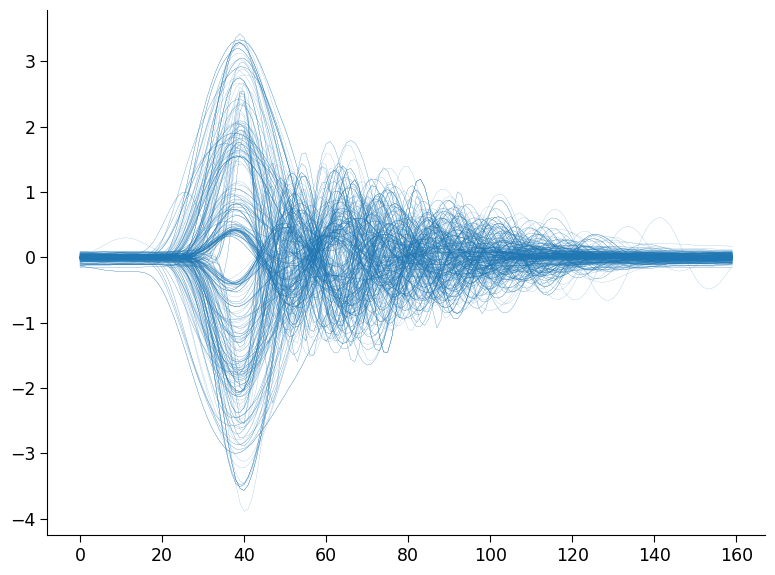

In [250]:
np.random.seed(23543)
ix = np.random.randint(0,bouts.shape[0],400)
bouts = bouts[ix]
# bouts = bouts[:400]
fig, ax = plt.subplots()
for bout in bouts:
    ax.plot(bout[6], c="C0", lw=.1)

In [251]:
# reshape and convert these bouts into a train
# ts = [np.concatenate([bout, np.zeros((bout.shape[0], 80+np.random.randint(0,20)))], axis=1) for bout in bouts[:400]]
# ts = np.concatenate(ts, axis=1)





## As a timeseries

In [252]:
n_bouts=20
mean_interbout=80
jitter_var=.01

ts=[]
for bout in bouts[:20]:
    # vary ibi
    # interbout_interval = np.zeros((bout.shape[0], mean_interbout + np.random.randint(-40,40)))
    interbout_interval = np.zeros((bout.shape[0], 1))
    # add noise to 0s
    interbout_interval += np.random.normal(0,jitter_var,interbout_interval.shape)
    # join ibi to bouts and append to timeseries
    ts.append(np.concatenate([bout, interbout_interval], axis=1))
ts = np.concatenate(ts, axis=1)    

[(0.0, 4000.0)]

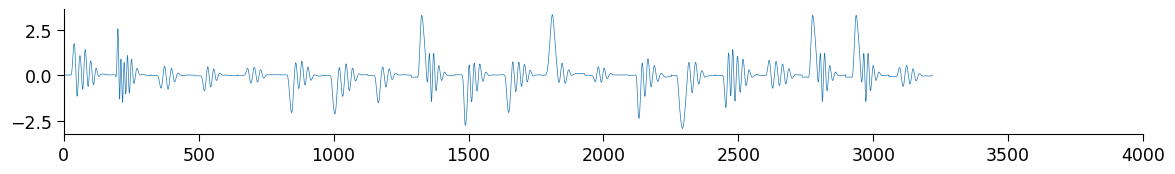

In [253]:
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(ts[6], c="C0",lw=.5)
ax.set(
    xlim=[0,4000]
)

[(0.0, 4000.0)]

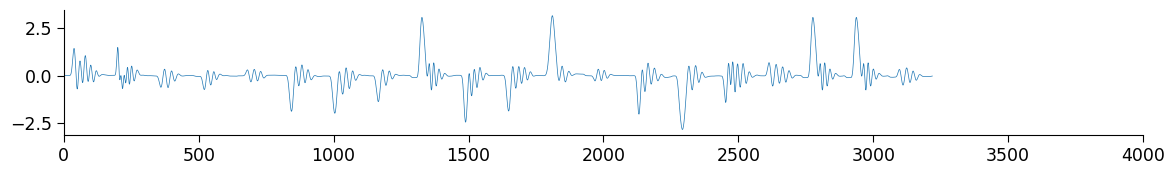

In [254]:
# smooth timeseries
from scipy.ndimage import gaussian_filter1d
ts = gaussian_filter1d(ts, sigma=3, axis=1)
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(ts[6], c="C0",lw=.5)
ax.set(
    xlim=[0,4000]
)

In [255]:
H = generate_hankel_matrix(ts, time_embedding=35)

rank: 119


[(0.9, 122.0), Text(0.5, 1.0, 'rank 119')]

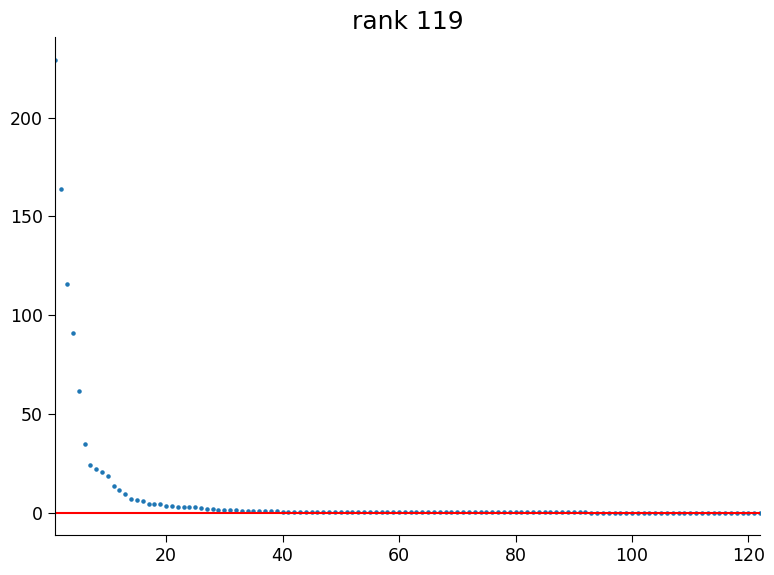

In [256]:
# Apply SVD
U, sv, Vh = LA.svd(H, full_matrices=0)
S = np.diag(sv)

# determine truncation
tau = svht(H, sv=sv)
r = sum(sv > tau)
print("rank:", r)
fig, ax = plt.subplots()
ax.scatter(range(1, len(sv) + 1), sv, s=5)
ax.axhline(tau, c='r')
ax.set(
    xlim=[.9, r+3],
    title=f"rank {r}",
)

In [257]:
r=120

In [258]:
from celluloid import Camera

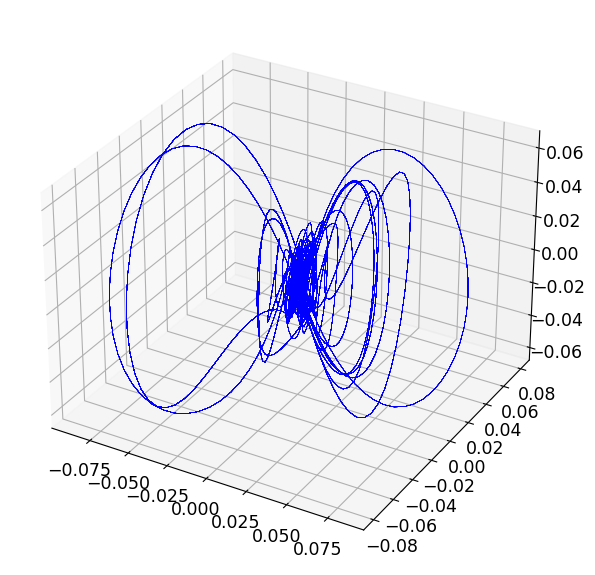

In [259]:
# set truncation
Utilde = U[:, :r]
Stilde = S[:r, :r]
Vtilde = Vh.conj().T[:, :r]

# plot embedded attractor
fig = plt.figure()
ax = plt.axes(projection="3d")
camera = Camera(fig)

for i in range(1, ts.shape[1], 25):
    ax.plot(Vtilde.T[0][:i], Vtilde.T[1][:i], Vtilde.T[2][:i], lw=0.2, color='blue')
    camera.snap()

# animation = camera.animate()
# animation.save('bout.gif', writer = 'imagemagick')

V50< -0.002213012102893097 V50> 0.03436298595200034
V51< -0.002573867344512093 V51> 0.08712035133589252
V53< 0.025885236801551803 V53> 0.13261787503508166
V54< 0.03289438274752657 V54> 0.08076700199948222
V56< -0.02380103713029373 V56> 0.08151982412685771
V57< 0.01470556294807851 V57> 0.1141763287502508
V58< 0.012184222448233126 V58> 0.054772617072192276
V59< 0.023726670517711962 V59> 0.12154334265959718
V60< -0.015243444265944109 V60> 0.0798126842004713
V63< 0.015437238038443851 V63> 0.09506535735062135
V64< 0.024805195361023685 V64> 0.12989052093255968
V65< -0.023603885275801456 V65> 0.07641477465151891
V66< -0.023615861871790017 V66> 0.08151040234245152
V68< 0.023207904518516162 V68> 0.11886284181935405
V69< 0.024850081013432876 V69> 0.07454004324770747
V70< -0.023858086143311044 V70> 0.0729411683344238
V71< 0.017446800694609743 V71> 0.11638031283210248
V72< 0.023033495755065497 V72> 0.1195655334341506
V73< -0.023459337010254586 V73> 0.07395597917213495
V74< -0.022334167434944235 V7

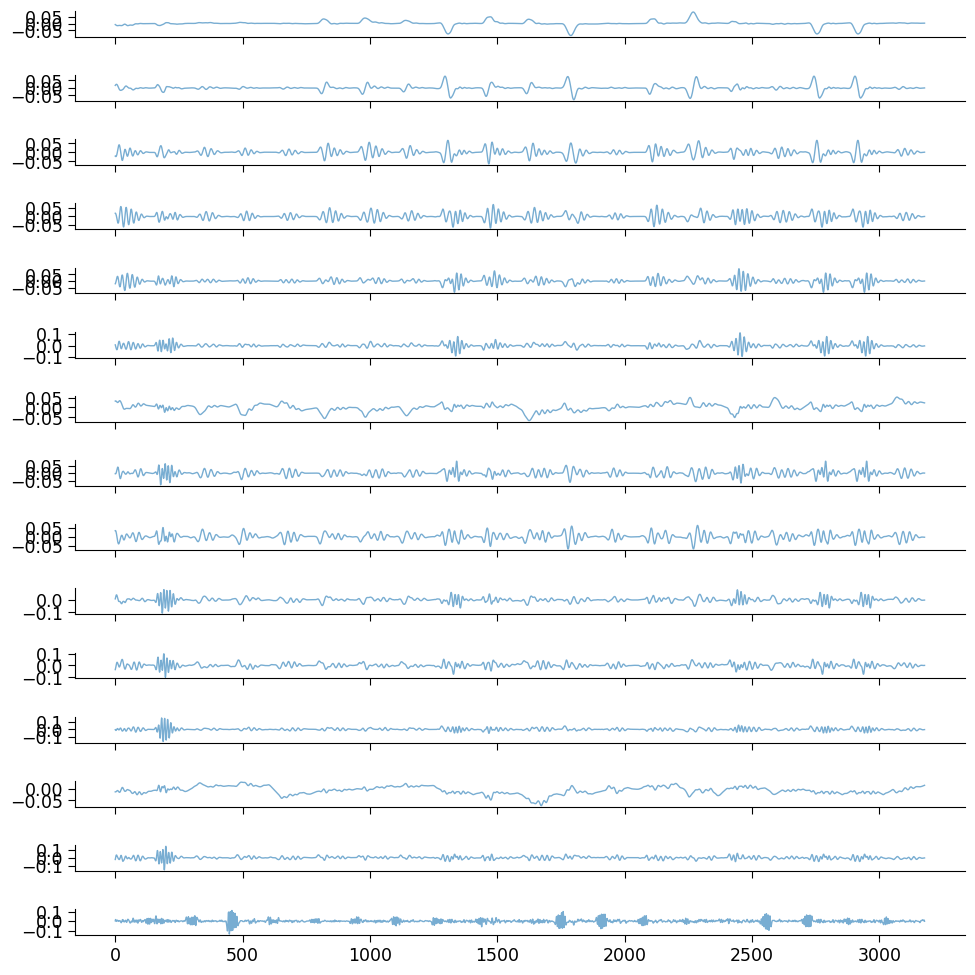

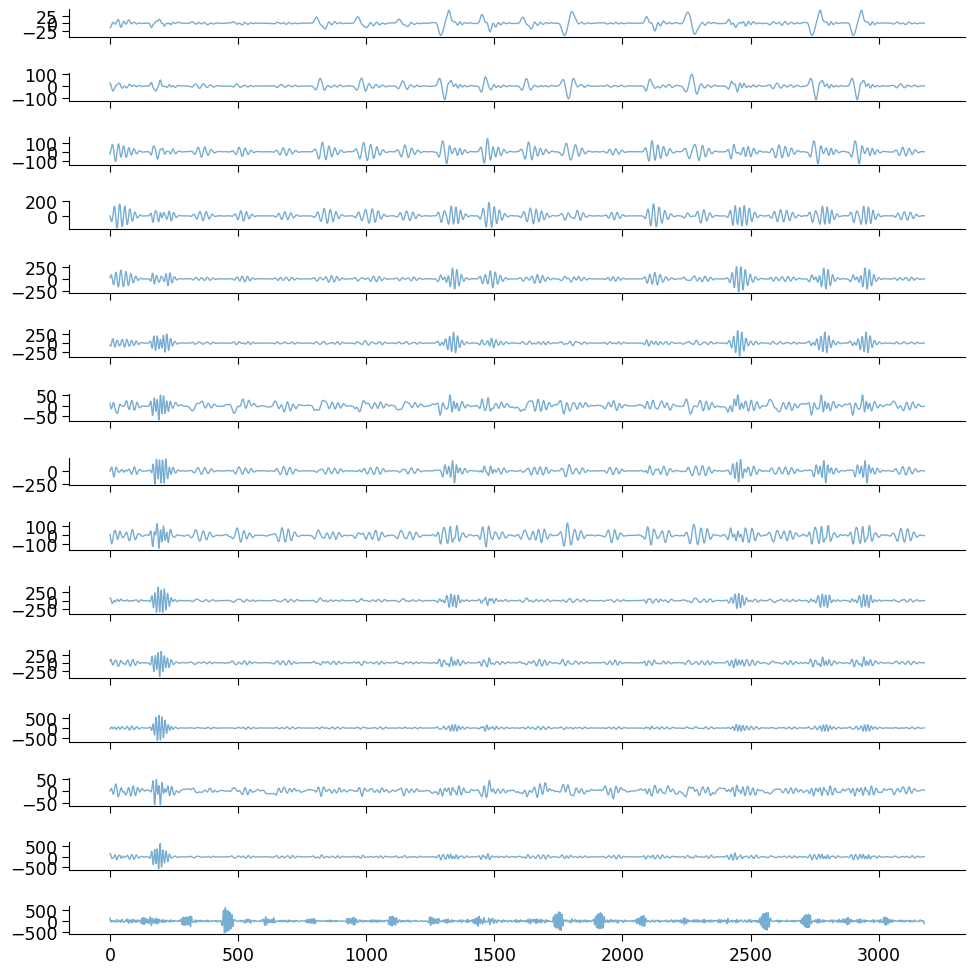

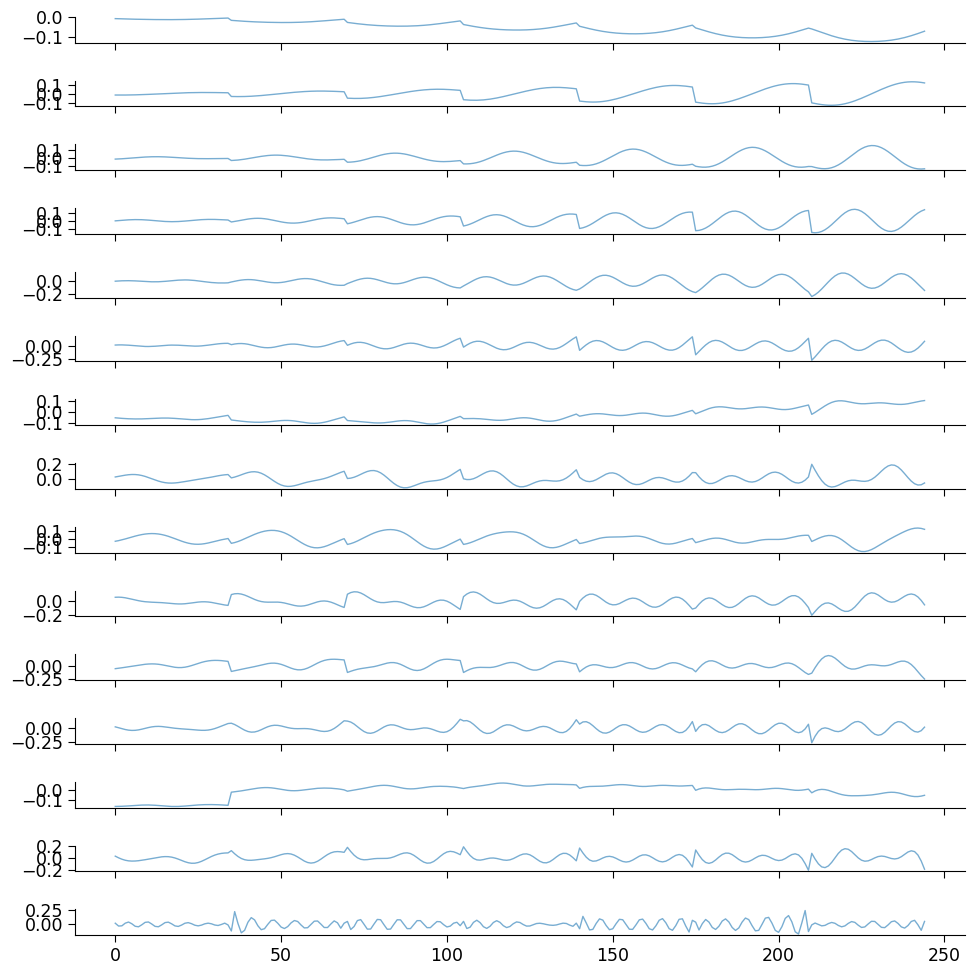

In [260]:
# Calculate time derivatives of eigen-timeseries
filter_len = 7
dVtilde_dt = np.r_[[robust_differentiator(Vtilde[:, i], dt=1 / (100 * 100), filter_length=filter_len) for i in
                    range(np.min(Vtilde.shape))]].T

# reshape eigen-timeseries
Vtilde = Vtilde[int((filter_len - 1) / 2):-int((filter_len - 1) / 2), :]
dVtilde_dt = dVtilde_dt[int((filter_len - 1) / 2):-int((filter_len - 1) / 2), :]

# plot eigen-timeseries
plot_time_series(Vtilde, threshold=15, r=r)
# plot eigen-timeseries time derivatives
plot_time_series(dVtilde_dt, threshold=15, r=r)
# plot eigen-spatial mode
plot_time_series(Utilde, threshold=15, r=r)

component_score = rank_forcing_component(Vtilde[:])
print(component_score)

In [244]:
component_score

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00],
       [ 4.00000000e+00,  0.00000000e+00],
       [ 5.00000000e+00,  0.00000000e+00],
       [ 6.00000000e+00,  0.00000000e+00],
       [ 7.00000000e+00,  0.00000000e+00],
       [ 8.00000000e+00,  0.00000000e+00],
       [ 9.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+01,  0.00000000e+00],
       [ 1.10000000e+01,  0.00000000e+00],
       [ 1.20000000e+01,  0.00000000e+00],
       [ 1.30000000e+01,  0.00000000e+00],
       [ 1.40000000e+01,  0.00000000e+00],
       [ 1.50000000e+01,  0.00000000e+00],
       [ 1.60000000e+01,  0.00000000e+00],
       [ 1.70000000e+01,  0.00000000e+00],
       [ 1.80000000e+01,  0.00000000e+00],
       [ 1.90000000e+01,  0.00000000e+00],
       [ 2.00000000e+01,  0.00000000e+00],
       [ 2.10000000e+01,  0.00000000e+00],
       [ 2.20000000e+01,  0.00000000e+00],
       [ 2.

/Users/thomasmullen/PycharmProjects/Havok-Method/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/Users/thomasmullen/PycharmProjects/Havok-Method/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


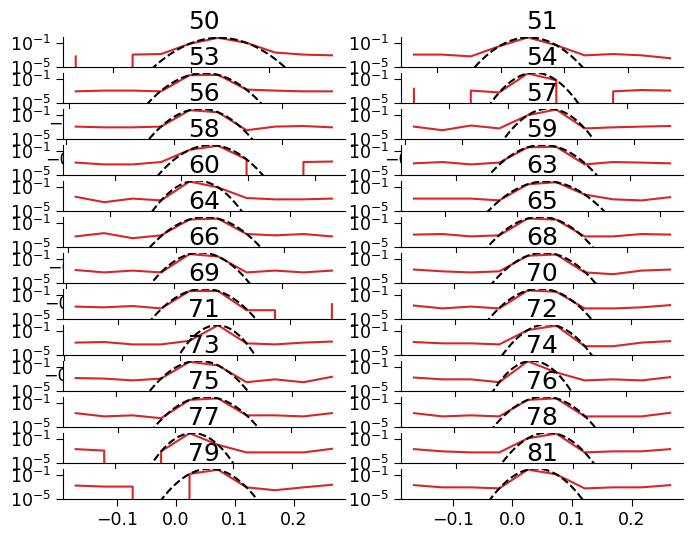

In [261]:
fig, axes = plt.subplots(np.sum(component_score.T[-1] > 0)//2, 2, layout="tight", sharex=False)
for i, ax in zip(component_score.T[0][component_score.T[-1] > 0].astype(int), axes.flatten()):
    real_x, real_y = calc_probability_distribution(Vtilde[:, i], n_bins=10)
    gauss_x, gauss_y = fit_gauss(Vtilde[:, i], n_bins=10)

    ax.plot(real_x, real_y, c='C3', label="raw")
    ax.plot(gauss_x, Gauss(gauss_x, *gauss_y), 'k--', label='gauss fit')
    ax.set(
        ylim=[10 ** -5, 1],
        yscale="log",
        title=f"{i}"
    )
    # ax.legend()

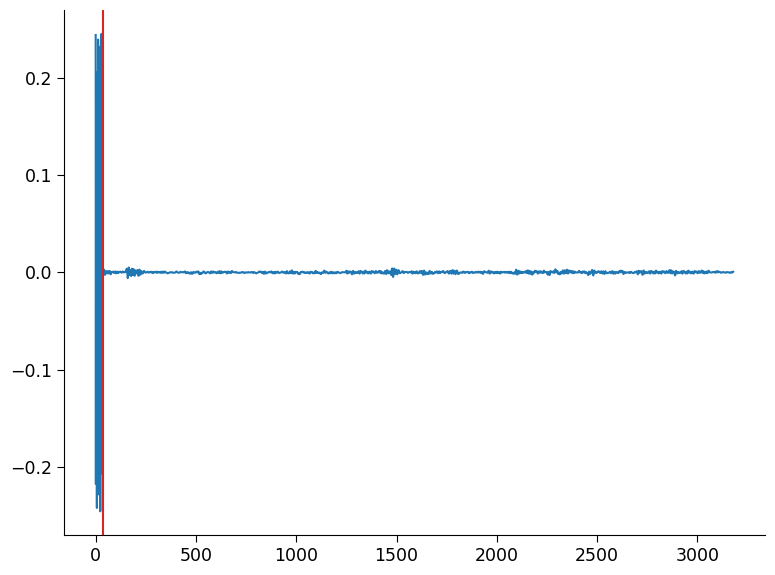

In [262]:
fig, ax = plt.subplots()
ax.plot(Vtilde[:,75])
ax.axvline(35,c="C3")

In [41]:
np.random.seed(34234)


bout 24909


[Text(0.5, 1.0, 'derivative')]

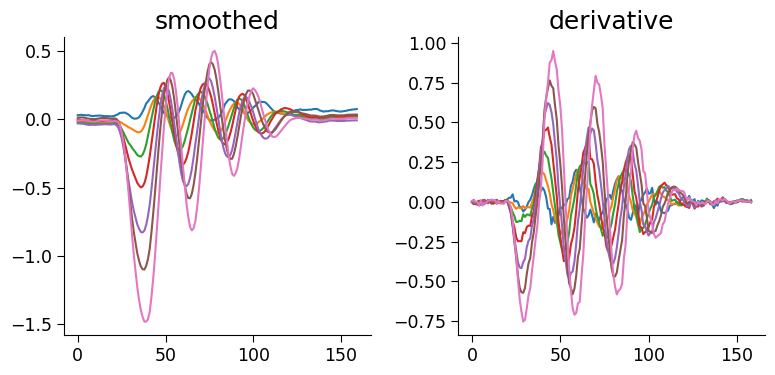

In [42]:
ix = np.random.randint(0, bouts.shape[0])
print("bout", ix)
bout = bouts[ix]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.plot(bout.T)
ax1.set(
    title="smoothed"
)
ax2.plot(bouts_deriv[ix].T)
ax2.set(
    title="derivative"
)

In [43]:
# generate hankel matrix
time_embedding=15
H = generate_hankel_matrix(bout, time_embedding=time_embedding)

rank: 47


Text(0.5, 1.0, 'rank: 47')

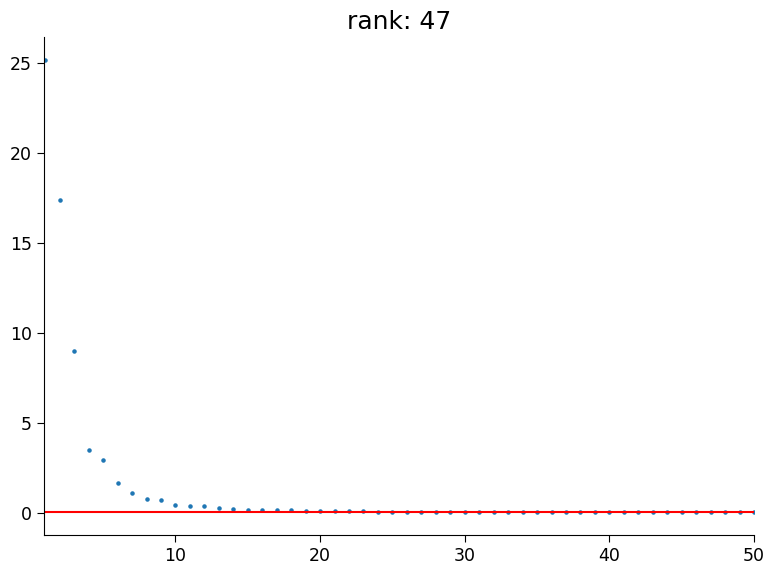

In [44]:
# Apply SVD
U, sv, Vh = LA.svd(H, full_matrices=0)
S = np.diag(sv)

# determine truncation
tau = svht(H, sv=sv)
r = sum(sv > tau)
print("rank:", r)
fig, ax = plt.subplots()
ax.scatter(range(1, len(sv) + 1), sv, s=5)
ax.axhline(tau, c='r')
ax.set_xlim([0.9, r + 3])
ax.set_title("rank: " + r.astype(str))

In [45]:
# set truncation
Utilde = U[:, :r]
Stilde = S[:r, :r]
Vtilde = Vh.conj().T[:, :r]

In [46]:
bout = bout.T

In [47]:
Vtilde.shape

(145, 47)

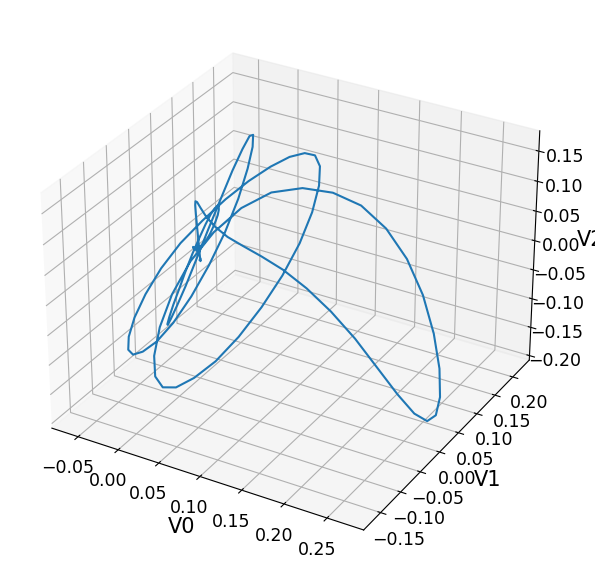

In [48]:
# plot predicted projection
fig = plt.figure()
ax = plt.axes(projection="3d")
# ax.grid(False)
# ax.axis('off')
ax.plot(Vtilde.T[0], Vtilde.T[1], Vtilde.T[4])
ax.set(
    xlabel="V0",
    ylabel="V1",
    zlabel="V2",
)
fig.tight_layout()

In [49]:

# Calculate time derivatives of eigen-timeseries
filter_len = 7
dVtilde_dt = np.r_[[robust_differentiator(Vtilde[:, i], dt=1 / (100 * 100), filter_length=filter_len) for i in
                    range(np.min(Vtilde.shape))]].T

In [50]:
# reshape eigen-timeseries
Vtilde = Vtilde[int((filter_len - 1) / 2):-int((filter_len - 1) / 2), :]
dVtilde_dt = dVtilde_dt[int((filter_len - 1) / 2):-int((filter_len - 1) / 2), :]

Text(0.5, 0.98, '$\\tilde{V}$')

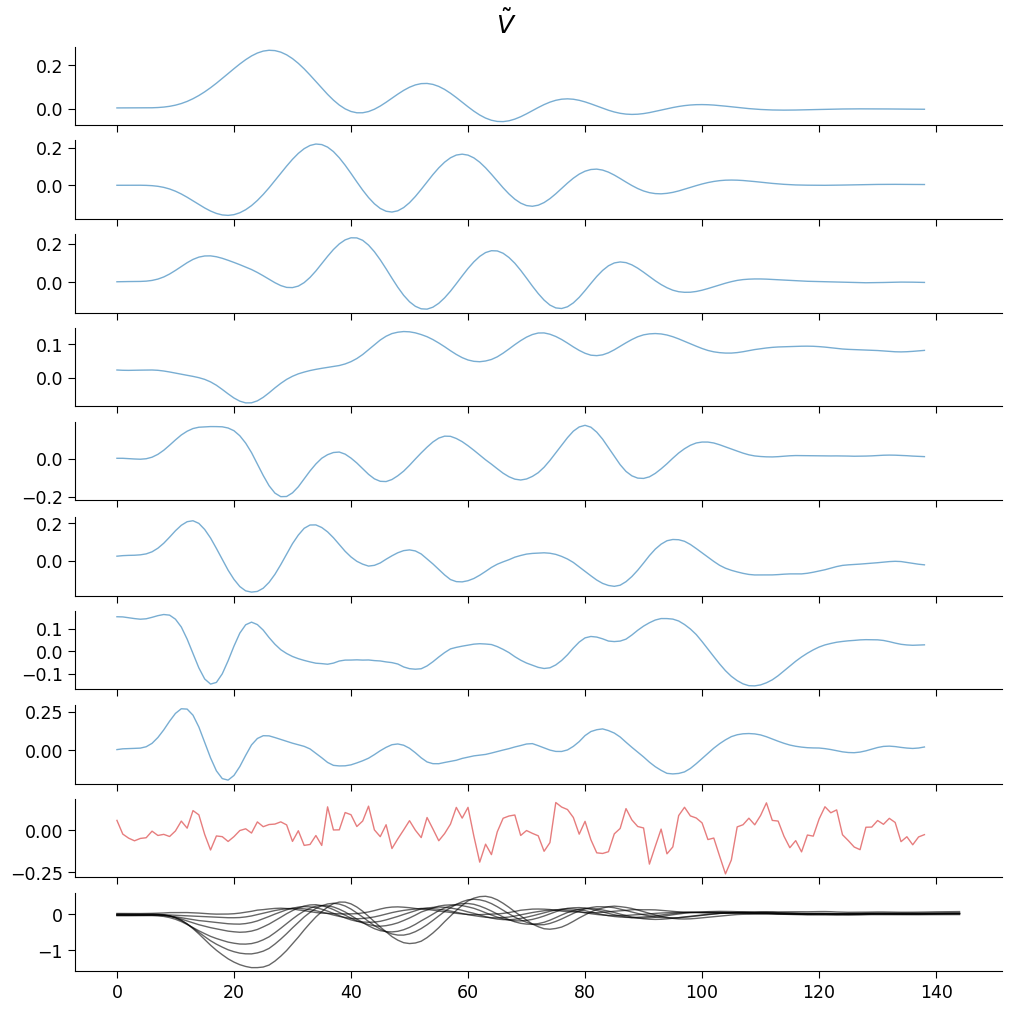

In [57]:
# plot eigen-timeseries
limit=10
fig, axes = plt.subplots(limit, 1, figsize=(10, 10), sharex=True, layout="constrained", sharey=False)
for i, ax in zip(range(limit - 2), axes):
    ax.plot(Vtilde[:, i], alpha=0.6, lw=1, label=str(i))
axes[-2].plot(Vtilde[:, -1], alpha=0.6, lw=1, label='r', c='C3')
axes[-1].plot(bout[time_embedding:], alpha=0.6, lw=1, label='r', c='k')
fig.suptitle(r"$\tilde{V}$")


Text(0.5, 0.98, '$\\partial_{t}\\tilde{V}$')

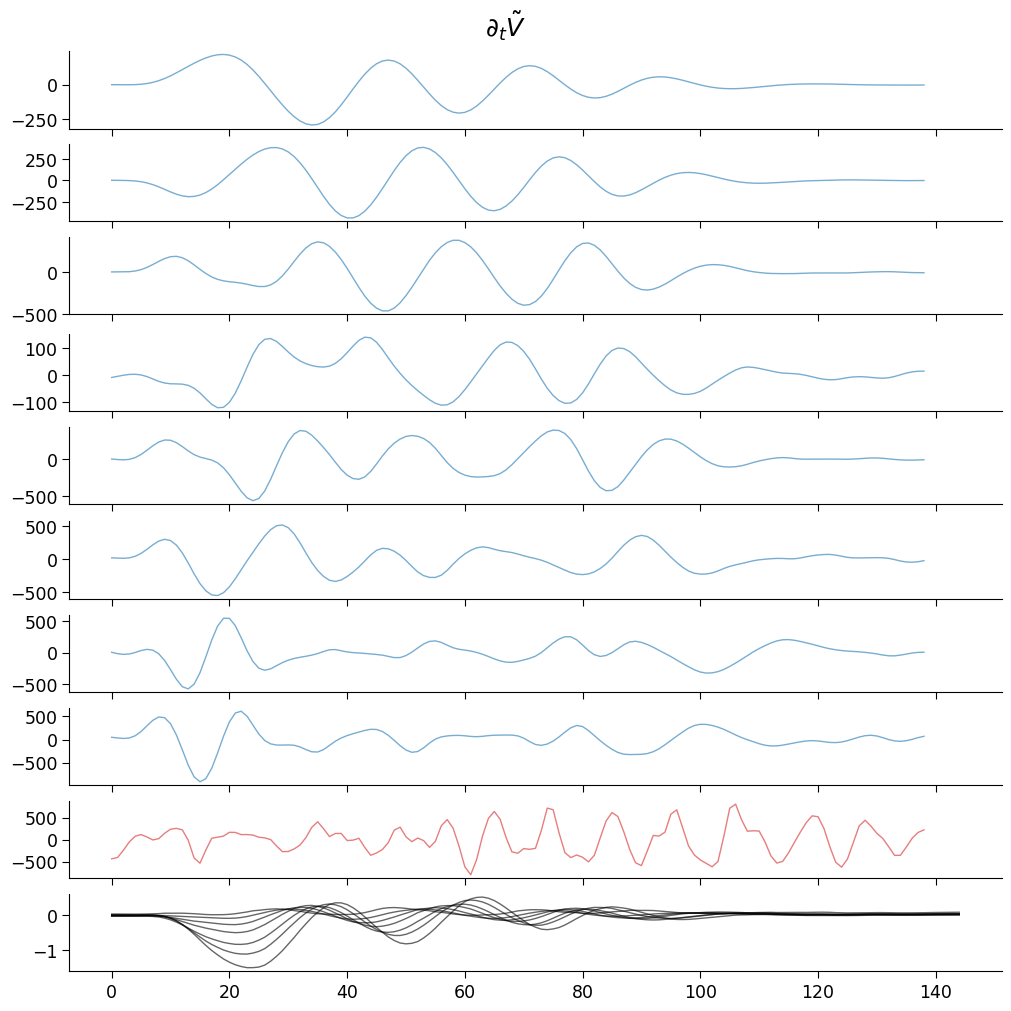

In [59]:
# plot eigen-timeseries
limit=10
fig, axes = plt.subplots(limit, 1, figsize=(10, 10), sharex=True, layout="constrained", sharey=False)
for i, ax in zip(range(limit - 2), axes):
    ax.plot(dVtilde_dt[:, i], alpha=0.6, lw=1, label=str(i))
axes[-2].plot(dVtilde_dt[:, -1], alpha=0.6, lw=1, label='r', c='C3')
axes[-1].plot(bout[time_embedding:], alpha=0.6, lw=1, label='r', c='k')
fig.suptitle(r"$\partial_{t}\tilde{V}$")

Text(0.5, 0.98, '$\\tilde{U}$')

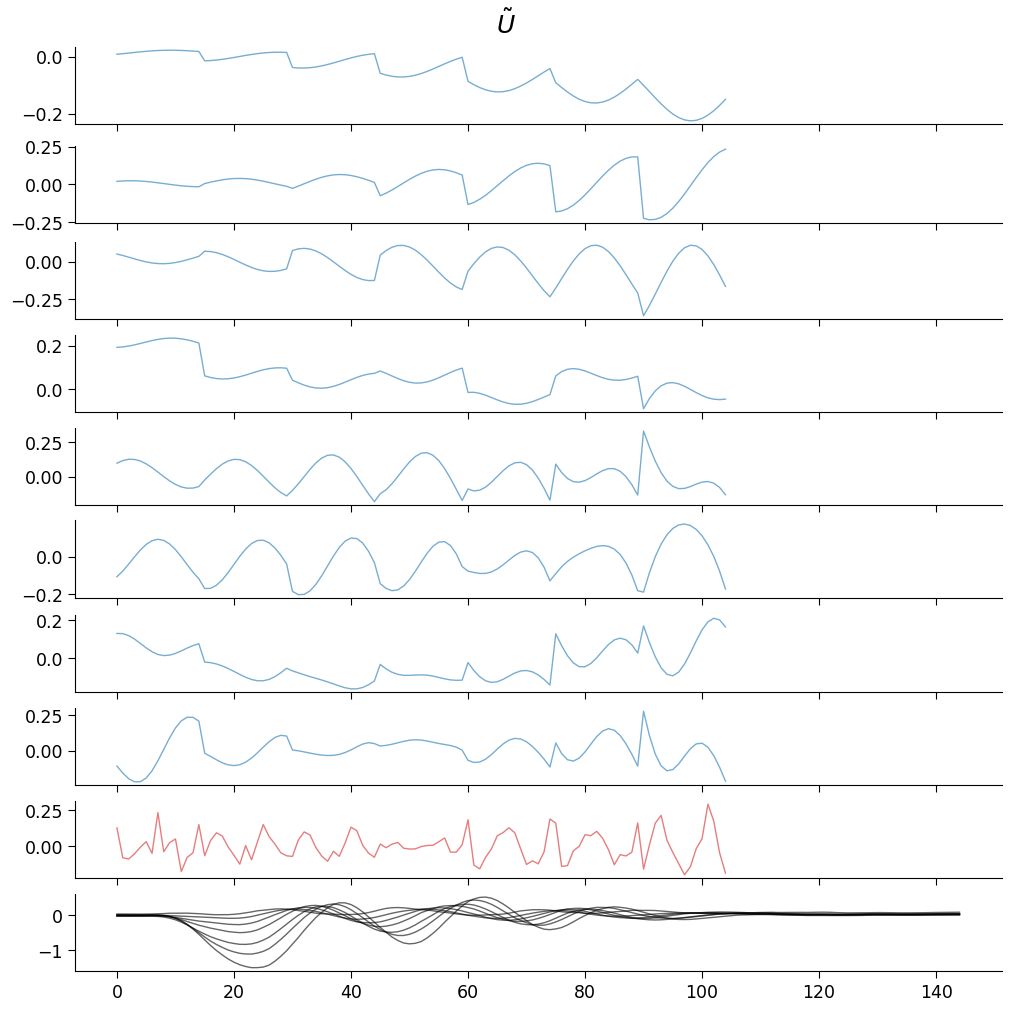

In [61]:
# plot eigen-timeseries
limit=10
fig, axes = plt.subplots(limit, 1, figsize=(10, 10), sharex=True, layout="constrained", sharey=False)
for i, ax in zip(range(limit - 2), axes):
    ax.plot(Utilde[:, i], alpha=0.6, lw=1, label=str(i))
axes[-2].plot(Utilde[:, -1], alpha=0.6, lw=1, label='r', c='C3')
axes[-1].plot(bout[time_embedding:], alpha=0.6, lw=1, label='r', c='k')
fig.suptitle(r"$\tilde{U}$")

In [65]:
# component_score = rank_forcing_component(Vtilde)
# print(component_score)
#
# fig, axes = plt.subplots(np.sum(component_score.T[-1] >= 0))
# for i, ax in zip(component_score.T[0][component_score.T[-1] >= 0].astype(int), axes):
#     real_x, real_y = calc_probability_distribution(Vtilde[:, i], n_bins=10)
#     gauss_x, gauss_y = fit_gauss(Vtilde[:, i], n_bins=10)
#
#     ax.plot(real_x, real_y, c='r', label="raw")
#     ax.plot(gauss_x, Gauss(gauss_x, *gauss_y), 'k--', label='gauss fit')
#     ax.set_yscale('log')
#     ax.set_ylim([10 ** -5, 1])
#     ax.legend()

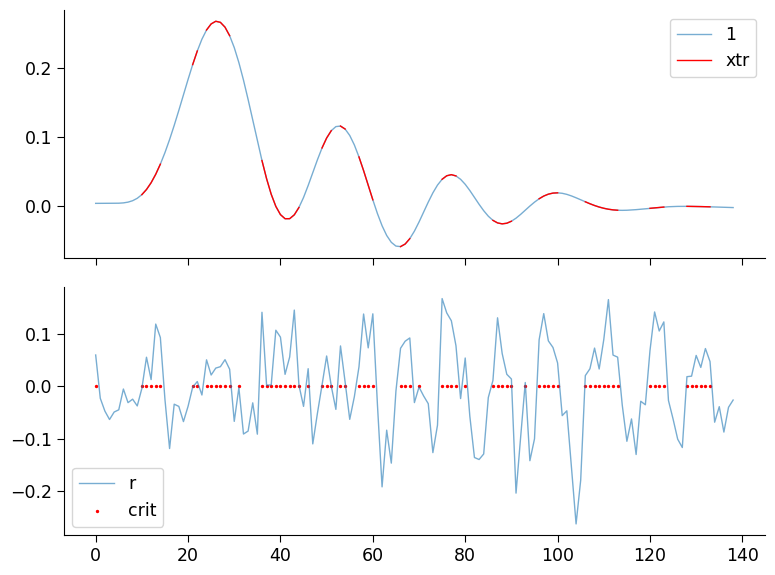

In [62]:
# mark regions along timeseries with intermittent forcing
real_x, real_y = calc_probability_distribution(Vtilde[:, -1], n_bins=10)
counts, edges = np.histogram(Vtilde[:, -1], bins=10)
gauss_x, gauss_y = fit_gauss(Vtilde[:, -1], n_bins=10)
idx_intercepts = np.argsort(np.abs(real_y - Gauss(real_x, *gauss_y)))[1:3]
upper_bound, lower_bound = np.max(edges[idx_intercepts]), np.min(edges[idx_intercepts])

# create masks for extreme values
extremes = np.where((Vtilde[:, -1] < lower_bound) | (Vtilde[:, -1] > upper_bound))
mx = np.ma.masked_array(Vtilde[:, 0], mask=[(Vtilde[:, -1] > lower_bound) & (Vtilde[:, -1] < upper_bound)])

# plot regions
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(Vtilde[:, 0], alpha=0.6, lw=1, label=str(1))
ax1.plot(mx, alpha=1, lw=1, label='xtr', c='r')
# ax1.scatter(extremes, np.repeat(0, len(extremes[0])), s=2, c='r', label='crit')
ax1.legend()

ax2.plot(Vtilde[:, -1], alpha=0.6, lw=1, label='r')
ax2.scatter(extremes, np.repeat(0, len(extremes[0])), s=2, c='r', label='crit')
ax2.legend()

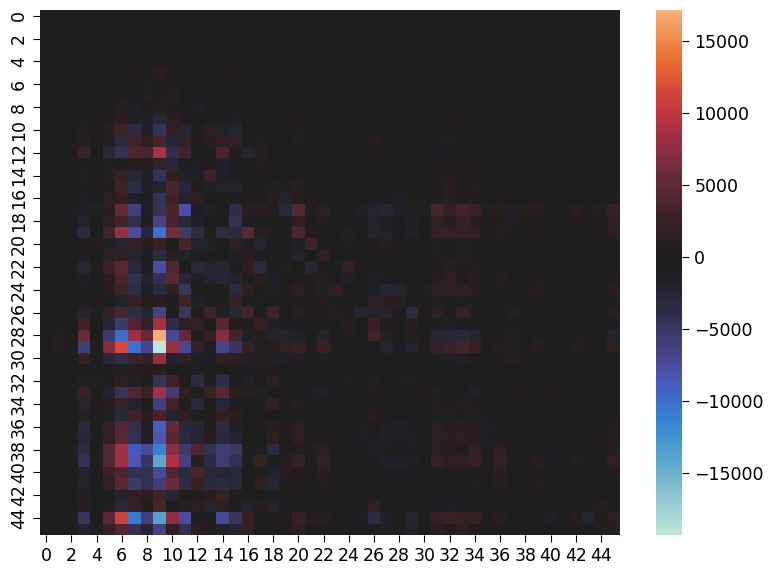

In [69]:
# linear regression:
reg = linear_model.LinearRegression()
reg.fit(Vtilde[100:600, :-1], dVtilde_dt[100:600, :-1])
A = reg.coef_
fig, ax = plt.subplots()
ax = sns.heatmap(A, center=0)
